
# Supplemental Information

This notebook is intended to serve as a supplement to the manuscript "High-throughput workflows for determining adsorption energies on solid surfaces."  It outlines basic use of the code and workflow software that has been developed for processing surface slabs and placing adsorbates according to symmetrically distinct sites on surface facets.

## Installation

To use this notebook, we recommend installing python via [Anaconda](https://www.continuum.io/downloads), which includes jupyter and the associated iPython notebook software.

The code used in this project primarily makes use of two packages, pymatgen and atomate, which are installable via pip or the matsci channel on conda (e. g. `conda install -c matsci pymatgen atomate`).  Development versions with editable code may be installed by cloning the repositories and using `python setup.py develop`.

## Example 1: AdsorbateSiteFinder (pymatgen)

An example using the the AdsorbateSiteFinder class in pymatgen is shown below.  We begin with an import statement for the necessay modules.  To use the MP RESTful interface, you must provide your own API key either in the MPRester call i.e. ```mpr=MPRester("YOUR_API_KEY")``` or provide in in your .pmgrc.yaml configuration file.  API keys can be accessed at materialsproject.org under your "Dashboard."

In [4]:
# Import statements
from pymatgen import Structure, Lattice, MPRester, Molecule
from pymatgen.analysis.adsorption import *
from pymatgen.core.surface import generate_all_slabs
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from matplotlib import pyplot as plt
%matplotlib inline
# Note that you must provide your own API Key, which can
# be accessed via the Dashboard at materialsproject.org
mpr = MPRester()

We create a simple fcc structure, generate it's distinct slabs, and select the slab with a miller index of (1, 1, 1).

In [2]:
fcc_ni = Structure.from_spacegroup("Fm-3m", Lattice.cubic(3.5), ["Ni"], [[0, 0, 0]])
slabs = generate_all_slabs(fcc_ni, max_index=1, min_slab_size=8.0,
                           min_vacuum_size=10.0)
ni_111 = [slab for slab in slabs if slab.miller_index==(1,1,1)][0]

We make an instance of the AdsorbateSiteFinder and use it to find the relevant adsorption sites.

In [3]:
asf_ni_111 = AdsorbateSiteFinder(ni_111)
ads_sites = asf_ni_111.find_adsorption_sites()
print(ads_sites)
assert len(ads_sites) == 4

{'ontop': [array([1.23743687, 0.71443451, 9.0725408 ])], 'bridge': [array([-0.61871843,  1.78608627,  9.0725408 ])], 'hollow': [array([4.27067681e-16, 7.39702921e-16, 9.07254080e+00]), array([8.80455477e-16, 1.42886902e+00, 9.07254080e+00])], 'all': [array([1.23743687, 0.71443451, 9.0725408 ]), array([-0.61871843,  1.78608627,  9.0725408 ]), array([4.27067681e-16, 7.39702921e-16, 9.07254080e+00]), array([1.63125081e-15, 1.42886902e+00, 9.07254080e+00])]}


We visualize the sites using a tool from pymatgen.

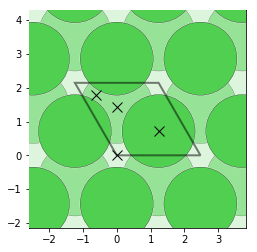

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_slab(ni_111, ax, adsorption_sites=True)

Use the `AdsorbateSiteFinder.generate_adsorption_structures` method to generate structures of adsorbates.

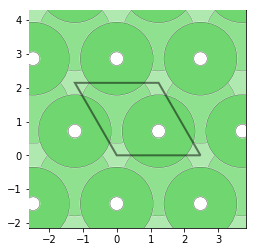

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
adsorbate = Molecule("H", [[0, 0, 0]])
ads_structs = asf_ni_111.generate_adsorption_structures(adsorbate, 
                                                        repeat=[1, 1, 1])
plot_slab(ads_structs[0], ax, adsorption_sites=False, decay=0.09)

## Example 2: AdsorbateSiteFinder for various surfaces

In this example, the AdsorbateSiteFinder is used to find adsorption sites on different structures and miller indices.

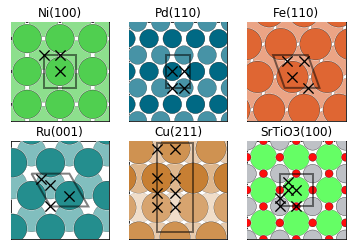

In [6]:
fig = plt.figure()
axes = [fig.add_subplot(2, 3, i) for i in range(1, 7)]
mats = {"mp-23":(1, 0, 0),   # FCC Ni
        "mp-2":(1, 1, 0),   # FCC Au
        "mp-13":(1, 1, 0),   # BCC Fe
        "mp-33":(0, 0, 1), # HCP Ru
        "mp-30": (2, 1, 1),
        "mp-5229":(1, 0, 0),
        } # Cubic SrTiO3
        #"mp-2133":(0, 1, 1)} # Wurtzite ZnO

for n, (mp_id, m_index) in enumerate(mats.items()):
    struct = mpr.get_structure_by_material_id(mp_id)
    struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
    slabs = generate_all_slabs(struct, 1, 5.0, 2.0, center_slab=True)
    slab_dict = {slab.miller_index:slab for slab in slabs}
    asf = AdsorbateSiteFinder.from_bulk_and_miller(struct, m_index, undercoord_threshold=0.10)
    plot_slab(asf.slab, axes[n])
    ads_sites = asf.find_adsorption_sites()
    sop = get_rot(asf.slab)
    ads_sites = [sop.operate(ads_site)[:2].tolist()
                 for ads_site in ads_sites["all"]]
    axes[n].plot(*zip(*ads_sites), color='k', marker='x', 
                 markersize=10, mew=1, linestyle='', zorder=10000)
    mi_string = "".join([str(i) for i in m_index])
    axes[n].set_title("{}({})".format(struct.composition.reduced_formula, mi_string))
    axes[n].set_xticks([])
    axes[n].set_yticks([])
    
axes[4].set_xlim(-2, 5)
axes[4].set_ylim(-2, 5)
fig.savefig('slabs.png', dpi=200)

In [7]:
!open slabs.png

## Example 3: Generating a workflow from atomate

In this example, we demonstrate how MatMethods may be used to generate a full workflow for the determination of DFT-energies from which adsorption energies may be calculated.  Note that this requires a working instance of  [FireWorks](https://pythonhosted.org/FireWorks/index.html) and its dependency, [MongoDB](https://www.mongodb.com/).  Note that MongoDB can be installed via [Anaconda](https://anaconda.org/anaconda/mongodb).

In [8]:
from fireworks import LaunchPad
lpad = LaunchPad()

In [9]:
lpad.reset('', require_password=False)

2019-03-26 11:18:12,187 INFO Performing db tune-up
2019-03-26 11:18:12,900 INFO LaunchPad was RESET.


Import the necessary workflow-generating function from atomate:

In [2]:
from atomate.vasp.workflows.base.adsorption import get_wf_slab, get_wfs_all_slabs

Adsorption configurations take the form of a dictionary with the miller index as a string key and a list of pymatgen Molecule instances as the values.

In [5]:
co = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
h = Molecule("H", [[0, 0, 0]])

Workflows are generated using the a slab a list of molecules.

In [10]:
struct = mpr.get_structure_by_material_id("mp-23") # fcc Ni
struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
slabs = generate_all_slabs(struct, 1, 5.0, 2.0, center_slab=True)
slab_dict = {slab.miller_index:slab for slab in slabs}

ni_slab_111 = slab_dict[(1, 1, 1)]
wf = get_wf_slab(ni_slab_111, adsorbates=[co, h])
lpad.add_wf(wf)

2019-03-26 11:18:16,698 INFO Added a workflow. id_map: {-18: 1, -17: 2, -16: 3, -15: 4, -14: 5, -13: 6, -12: 7, -11: 8, -10: 9}


{-18: 1, -17: 2, -16: 3, -15: 4, -14: 5, -13: 6, -12: 7, -11: 8, -10: 9}

The workflow may be inspected as below.  Note that there are 9 optimization tasks correponding the slab, and 4 distinct adsorption configurations for each of the 2 adsorbates.  Details on running FireWorks, including [singleshot launching](https://pythonhosted.org/FireWorks/worker_tutorial.html#launch-a-rocket-on-a-worker-machine-fireworker), [queue submission](https://pythonhosted.org/FireWorks/queue_tutorial.html#), [workflow management](https://pythonhosted.org/FireWorks/defuse_tutorial.html), and more can be found in the [FireWorks documentation](https://pythonhosted.org/FireWorks/index.html).

In [11]:
lpad.get_wf_summary_dict(1)

{'state': 'READY',
 'name': 'Ni1_(1, 1, 1) slab workflow',
 'created_on': datetime.datetime(2019, 3, 26, 18, 18, 16, 552000),
 'updated_on': datetime.datetime(2019, 3, 26, 18, 18, 16, 552000),
 'states': OrderedDict([('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 3--1',
               'READY'),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 2--2', 'READY'),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 1--3', 'READY'),
              ('Ni27H-H1-Ni_(1, 1, 1) adsorbate optimization 0--4', 'READY'),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 3--5',
               'READY'),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 2--6',
               'READY'),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 1--7',
               'READY'),
              ('Ni27CO-C1 O1-Ni_(1, 1, 1) adsorbate optimization 0--8',
               'READY'),
              ('Ni-Ni_(1, 1, 1) slab optimization--9', 'READY')]),
 'launch_dirs':

Note also that running FireWorks via atomate may require system specific tuning (e. g. for VASP parameters).  More information is available in the [atomate documentation](http://pythonhosted.org/atomate/).

## Example 4 - Screening of oxygen evolution electrocatalysts on binary oxides

This final example is intended to demonstrate how to use the MP API and the adsorption workflow to do an initial high-throughput study of oxygen evolution electrocatalysis on binary oxides of transition metals.

In [12]:
from pymatgen.core.periodic_table import *
from pymatgen.core.surface import get_symmetrically_distinct_miller_indices
import tqdm

lpad.reset('', require_password=False)

2019-03-26 11:18:26,565 INFO Performing db tune-up
2019-03-26 11:18:26,642 INFO LaunchPad was RESET.


For oxygen evolution, a common metric for the catalytic activity of a given catalyst is the theoretical overpotential corresponding to the mechanism that proceeds through OH\*, O\*, and OOH\*.  So we can define our adsorbates:

In [13]:
OH = Molecule("OH", [[0, 0, 0], [-0.793, 0.384, 0.422]])
O = Molecule("O", [[0, 0, 0]])
OOH = Molecule("OOH", [[0, 0, 0], [-1.067, -0.403, 0.796], 
                       [-0.696, -0.272, 1.706]])
adsorbates = [OH, O, OOH]

Then we can retrieve the structures using the MP rest interface, and write a simple for loop which creates all of the workflows corresponding to every slab and every adsorption site for each material.  The code below will take ~15 minutes.  This could be parallelized to be more efficient, but is not for simplicity in this case.

In [ ]:
elements = [Element.from_Z(i) for i in range(1, 103)]
trans_metals = [el for el in elements if el.is_transition_metal]
# tqdm adds a progress bar so we can see the progress of the for loop
for metal in tqdm.tqdm_notebook(trans_metals):
    # Get relatively stable structures with small unit cells
    data = mpr.get_data("{}-O".format(metal.symbol))
    data = [datum for datum in data if datum["e_above_hull"] < 0.05]
    data = sorted(data, key = lambda x: x["nsites"])
    struct = Structure.from_str(data[0]["cif"], fmt='cif')
    # Put in conventional cell settings
    struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
    # Get distinct miller indices for low-index facets
    wfs = get_wfs_all_slabs(struct, adsorbates=adsorbates)
    for wf in wfs:
        lpad.add_wf(wf)
    print("Processed: {}".format(struct.formula))

Ultimately, running this code produces workflows that contain many (tens of thousands) of calculations, all of which can be managed using FireWorks and queued on supercomputing resources.  Limitations on those resources might necessitate a more selective approach towards choosing surface facets or representative materials.  Nevertheless, this approach represents a way to provide for a complete and structurally accurate way of screening materials for adsorption properties than can be managed using fireworks.